In [ ]:
%load_ext autoreload
%autoreload 2

In [7]:
from condition_prediction.run import ConditionPrediction
import wandb
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from tqdm import tqdm
import gc

In [4]:
api = wandb.Api()
wandb_entity="ceb-sre"
wandb_project="orderly"

In [13]:
BASE_PATH = pathlib.Path("/project/studios/orderly-preprocessing/ORDerly/")
DATASETS_PATH = BASE_PATH / "data/orderly/datasets/"
MODEL_PATH = pathlib.Path("ORDerly/models/")
dataset = "no_trust_with_map"
filters = {
    # "state": "crashed",
    "config.output_folder_path": {
        "$in": [
            f"models/{dataset}",
            str(MODEL_PATH / dataset),
            f"/Users/Kobi/Documents/Research/phd_code/ORDerly/models/{dataset}",
        ],
    },
    "config.random_seed": 12345,
    "config.train_fraction": 0.2,
    "config.dataset_version": "v4",
    "config.train_mode": 0,  # Teacher forcing
}
# filters = {
#     "id": {"$in": ["zl4inibc", "mdwxixa4", "zbx7fqj5"]}
# }
runs = api.runs(f"{wandb_entity}/{wandb_project}", filters=filters)
# if not len(runs) == 5: # For 5 training fractions
#     raise ValueError(f"Not 5 runs for {dataset} (found {len(runs)}, seed {random_seed})")

for run in runs:
    config = dict(run.config)
    train_data_path = pathlib.Path(
        f"{DATASETS_PATH}/orderly_{dataset}_train.parquet"
    )
    test_data_path = pathlib.Path(
        f"{DATASETS_PATH}/orderly_{dataset}_test.parquet"
    )
    fp_directory = train_data_path.parent / "fingerprints"
    train_fp_path = fp_directory / (train_data_path.stem + ".npy")
    test_fp_path = fp_directory / (test_data_path.stem + ".npy")
    output_folder_path = MODEL_PATH / dataset
    output_folder_path.mkdir(parents=True, exist_ok=True)
    tags = dataset.split("_")
    tags = [f"{tags[0]}_{tags[1]}", f"{tags[2]}_{tags[3]}"]
    config.update(
        {
            "train_data_path": train_data_path,
            "test_data_path": test_data_path,
            "train_fp_path": train_fp_path,
            "test_fp_path": test_fp_path,
            "output_folder_path": output_folder_path,
            "skip_training": True,
            "resume": True,
            "resume_from_best": True,
            "generate_fingerprints": False,
            "wandb_run_id": run.id,
            "wandb_tags": tags,
        }
    )
    del config["n_val"]
    del config["n_test"]
    del config["n_train"]
    del config["dataset_version"]
    instance = ConditionPrediction(**config)
    instance.run_model_arguments()
    wandb.finish()
    gc.collect()

Prefetch buffer size: -1
Prefetch buffer size: -1
Prefetch buffer size: -1


wandb: Downloading large artifact run_zbx7fqj5_model:v1, 67.03MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0
wandb: Downloading large artifact run_zbx7fqj5_model:v0, 67.03MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.2


139/139 [==============================] - 2s 10ms/step


2023-06-07 02:16:06.394389: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


139/139 [==============================] - 1s 10ms/step


2023-06-07 02:17:33.114064: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


73/73 [==============================] - 1s 10ms/step


2023-06-07 02:19:00.864700: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


73/73 [==============================] - 1s 11ms/step


2023-06-07 02:19:40.395855: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


epoch/epoch,99
epoch/learning_rate,0.01
epoch/loss,1.09914
epoch/mol1_acc,0.91118
epoch/mol1_loss,0.2798
epoch/mol1_top3,0.98683
epoch/mol1_top5,0.99557
epoch/mol2_acc,0.93469
epoch/mol2_loss,0.20221
epoch/mol2_top3,0.99249
epoch/mol2_top5,0.99727


In [12]:
len(runs)

0

## Generate Table 

In [25]:
DATASETS = ["with_trust_with_map","with_trust_no_map", "no_trust_no_map", "no_trust_with_map"]
lines = ["Solvents", "Agents", "Solvents \& Agents"]
top_n = 3
for dataset in DATASETS:
    filters = {
        "state": "finished",
        "config.output_folder_path": f"models/{dataset}",
        "config.random_seed": 54321,
        "config.train_fraction": 1.0,
        "config.train_mode": 0, # Teacher forcing
    }
    runs = api.runs(
        f"{wandb_entity}/{wandb_project}",
        filters=filters
    )
    assert len(runs) == 1
    run = runs[0]

    # Get model solvent, agent and overall accuracy
    test_best = run.summary["test_best"]
    solvent_accuracy = test_best[f"solvent_accuracy_top{top_n}"]
    agent_accuracy = test_best[f"three_agents_accuracy_top{top_n}"]
    overall_accuracy = test_best[f"overall_accuracy_top{top_n}"]

    # Get frequency informed solvent, agent and overall accuracy
    fi_solvent_accuracy = run.summary[f"frequency_informed_solvent_accuracy_top_{top_n}"]
    fi_agent_accuracy = run.summary[f"frequency_informed_agent_accuracy_top_{top_n}"]
    fi_overall_accuracy = run.summary[f"frequency_informed_overall_accuracy_top_{top_n}"]

    # Improvement
    solvent_improvement = (solvent_accuracy-fi_solvent_accuracy)/(1-fi_solvent_accuracy)
    solvent_improvement_color = "lessgreen" if solvent_improvement>0 else "red"
    agent_improvement = (agent_accuracy-fi_agent_accuracy)/(1-fi_agent_accuracy)
    agent_improvement_color = "lessgreen" if agent_improvement>0 else "red"
    overall_improvement = (overall_accuracy-fi_overall_accuracy)/(1-fi_overall_accuracy)
    overall_improvement_color = "lessgreen" if overall_improvement>0 else "red"

    # Create table lines
    lines[0] += f" & {fi_solvent_accuracy*100:.0f} // {solvent_accuracy*100:.0f} // \\textcolor{{{solvent_improvement_color}}}{{{solvent_improvement*100:.0f}\%}} "
    lines[1] += f" & {fi_agent_accuracy*100:.0f} // {agent_accuracy*100:.0f} // \\textcolor{{{agent_improvement_color}}}{{{agent_improvement*100:.0f}\%}} "
    lines[2] += f" & {fi_overall_accuracy*100:.0f} // {overall_accuracy*100:.0f} // \\textcolor{{{overall_improvement_color}}}{{{overall_improvement*100:.0f}\%}} "
print("\\\\ \n".join(lines) + "\\\\")

Solvents & 34 // 52 // \textcolor{lessgreen}{28\%}  & 34 // 53 // \textcolor{lessgreen}{30\%}  & 24 // 45 // \textcolor{lessgreen}{28\%}  & 23 // 42 // \textcolor{lessgreen}{26\%} \\ 
Agents & 43 // 65 // \textcolor{lessgreen}{39\%}  & 43 // 67 // \textcolor{lessgreen}{43\%}  & 21 // 42 // \textcolor{lessgreen}{27\%}  & 19 // 39 // \textcolor{lessgreen}{25\%} \\ 
Solvents \& Agents & 18 // 39 // \textcolor{lessgreen}{26\%}  & 19 // 41 // \textcolor{lessgreen}{27\%}  & 5 // 24 // \textcolor{lessgreen}{21\%}  & 4 // 21 // \textcolor{lessgreen}{18\%} \\


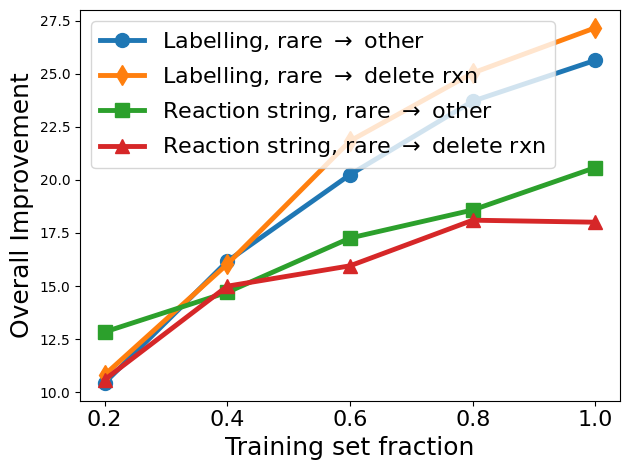

In [45]:
DATASETS = ["with_trust_with_map","with_trust_no_map", "no_trust_no_map", "no_trust_with_map"]
LABELS = {
    "with_trust_with_map": r"Labelling, rare $\rightarrow$ other",
    "with_trust_no_map": r"Labelling, rare $\rightarrow$ delete rxn",
    "no_trust_no_map": r"Reaction string, rare $\rightarrow$ other",
    "no_trust_with_map": r"Reaction string, rare $\rightarrow$ delete rxn",
}
TRAIN_FRACS =  [0.2, 0.4, 0.6, 0.8, 1.0]
fig, ax = plt.subplots(1)
markers = ["o", "d", "s", "^"]
top_n = 3
for i, dataset in enumerate(DATASETS):
    overall_accuracies = []
    for train_fraction in TRAIN_FRACS:
        filters = {
            "state": "finished",
            "config.output_folder_path": f"models/{dataset}",
            # "config.random_seed": {"$in": [12345, 54321, 98765]},
            "config.random_seed": 54321,
            "config.train_fraction": train_fraction,
            "config.train_mode": 0, # Teacher forcing
        }
        runs = api.runs(
            f"{wandb_entity}/{wandb_project}",
            filters=filters
        )
        assert len(runs) == 1
        run = runs[0]

        # Get overall accuracy
        acc_local = []
        for run in runs:
            overall_accuracy = run.summary[f"test_best"][f"overall_accuracy_top{top_n}"]
            fi_overall_accuracy = run.summary[f"frequency_informed_overall_accuracy_top_{top_n}"]
            overall_improvement = (overall_accuracy-fi_overall_accuracy)/(1-fi_overall_accuracy)
            acc_local.append(overall_improvement)
        overall_accuracies.append(np.mean(overall_improvement)*100)
    
    # Add line to plot
    label = LABELS[dataset]
    ax.plot(
        TRAIN_FRACS, 
        overall_accuracies, 
        label=label, 
        linewidth=3.5, 
        marker=markers[i], 
        markersize=10,
    )

# Formatting
axis_fontsize = 16
heading_fontsize = 18
ax.legend(loc="upper left", fontsize=axis_fontsize)
ax.set_xlabel("Training set fraction", fontsize=heading_fontsize)
ax.set_ylabel("Overall Improvement",  fontsize=heading_fontsize)
ax.set_xticks(TRAIN_FRACS)
ax.set_xticklabels(TRAIN_FRACS, fontsize=axis_fontsize)
# ylabels = np.arange(0.1, 0.35, 0.05)
# ax.set_yticks(ylabels)
# ax.set_yticklabels([f"{ylabel:0.2f}" for ylabel in ylabels], fontsize=axis_fontsize)
fig.tight_layout()
fig.savefig("scaling_behavior.png", dpi=300)

In [40]:
len(runs)

2

In [41]:
train_fraction

1.0

In [42]:
dataset

'with_trust_no_map'